In [1]:
import time
import numpy as np
import dxchange
from utils import nor_phase
from ganrec2 import GANphase
import os
from lib import visualize
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# import tensorflow_addons as tfa
import tensorflow as tf
import skimage.io as io

In [2]:
energy = 11
z = 7.8880960e-2
pv = 1.04735263e-7
iter_num = 700

fname_data = 'data/gan_phase/data_spider.tif'
kwargs = {'energy': energy, 'z': z, 'pv': pv, 'iter_num': iter_num, 'phase_only': False, 'save_wpath': 'data/gan_phase/spider_abs_ratio/', 'init_wpath': 'data/gan_phase/spider_abs_ratio/', 'init_model': False}
data = dxchange.read_tiff(fname_data)
nprj, px,  py = data.shape
data = nor_phase(data)
abs_ratio = 0.01

In [265]:
import tensorflow as tf
from tensorflow_addons.image import median_filter2d

import numpy as np

from models import *
from utils import *

from joblib import Parallel, delayed


# @tf.function
def discriminator_loss(real_output, fake_output):
    real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_output,
                                                                       labels=tf.ones_like(real_output)))
    fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_output,
                                                                       labels=tf.zeros_like(fake_output)))
    total_loss = real_loss + fake_loss
    return total_loss


def l1_loss(img1, img2):
    return tf.reduce_mean(tf.abs(img1 - img2))
def l2_loss(img1, img2):
    return tf.square(tf.reduce_mean(tf.abs(img1-img2)))



# @tf.function
def generator_loss(fake_output, img_output, pred, l1_ratio):
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_output,
                                                                      labels=tf.ones_like(fake_output))) \
               + l1_loss(img_output, pred) * l1_ratio
    return gen_loss


# @tf.function
def filer_loss(fake_output, img_output, img_filter):
    f_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_output,
                                                                    labels=tf.ones_like(fake_output))) + \
              l1_loss(img_output, img_filter) *10
              # l1_loss(img_output, img_filter) * 10
    return f_loss


def tfnor_tomo(img):
    img = tf.image.per_image_standardization(img)
    img = img / tf.reduce_max(img)
    img = img - tf.reduce_min(img)
    # img = (img - tf.reduce_min(img)) / (tf.reduce_max(img) - tf.reduce_min(img))
    return img


def tfnor_phase(img):
    img = tf.image.per_image_standardization(img)
    img = img / tf.reduce_max(img)
    return img

def tfnor_diff(img):
    # img = tf.image.per_image_standardization(img)
    # img = img / tf.reduce_max(img)
    # img = img - tf.reduce_min(img)
    img = (img - tf.reduce_min(img)) / (tf.reduce_max(img) - tf.reduce_min(img))
    return img


def avg_results(recon, loss):
    sort_index = np.argsort(loss)
    recon_tmp = recon[sort_index[:10], :, :, :]
    return np.mean(recon_tmp, axis=0)



def phase_fresnel(phase, absorption, ff, px):
    paddings = tf.constant([[px // 2, px // 2], [px // 2, px // 2]])
    # padding1 = tf.constant([[px // 2, px // 2], [0, 0]])
    # padding2 = tf.constant([[0, 0], [px // 2, px // 2]])
    pvalue = tf.reduce_mean(phase[:100, :])
    # phase = tf.pad(phase, paddings, 'CONSTANT',constant_values=1)
    phase = tf.pad(phase, paddings, 'SYMMETRIC')
    # phase = tf.pad(phase, paddings, 'REFLECT')
    absorption = tf.pad(absorption, paddings, 'SYMMETRIC')
    # phase = phase
    # absorption = absorption
    abfs = tf.complex(-absorption, phase)
    abfs = tf.exp(abfs)
    ifp = tf.abs(tf.signal.ifft2d(ff * tf.signal.fft2d(abfs))) ** 2
    ifp = tf.reshape(ifp, [ifp.shape[0], ifp.shape[1], 1])
    ifp = tf.image.central_crop(ifp, 0.5)
    ifp = tf.image.per_image_standardization(ifp)
    ifp = tf.reshape(ifp, [1, ifp.shape[0], ifp.shape[1], 1])
    # ifp = tfnor_phase(ifp)
    return ifp


def phase_fraunhofer(phase, absorption):
    wf = tf.complex(absorption, phase)
    # wf = tf.complex(phase, absorption)

    # wf = mask_img(wf)
    # wf = tf.multiply(ampl, tf.exp(phshift))
    # wf = tf.manip.roll(wf, [160, 160], [0, 1])
    ifp = tf.square(tf.abs(tf.signal.fft2d(wf)))
 
    
    # # adding log to the fft
    # ifp = tf.math.log(ifp+8000)
    ifp = tf.math.log(ifp+10000)
    # ifp = tf.math.log(tf.abs(tf.signal.fft2d(wf))+1)
    # ifp = tf.math.log(tf.square(tf.abs(tf.signal.fft2d(wf)))+1)
    ifp = tf.signal.fftshift(ifp)
  
    # ifp = tf.roll(ifp, [256, 256], [0, 1])
    ifp = tf.reshape(ifp, [1, ifp.shape[0], ifp.shape[1], 1])
    ifp = tf.image.per_image_standardization(ifp)
    ifp = tfnor_diff(ifp)
    return ifp


def diffusion_layer(input_tensor, sigma=1.0):
    size = int(sigma*4)
    x = tf.linspace(-3.0, 3.0, size)
    z = (1.0/(sigma*tf.sqrt(2.0*3.1415)))*tf.exp(-tf.square(x)/(2.0*sigma*sigma))
    z_2d = tf.matmul(tf.reshape(z, [size, 1]), tf.reshape(z, [1, size]))
    z_4d = tf.reshape(z_2d, [size, size, 1, 1])
    return tf.nn.depthwise_conv2d(input_tensor, z_4d, [1, 1, 1, 1], 'SAME')


class GANphase:
    def __init__(self, i_input, energy, z, pv, **kwargs):
        phase_args = _get_GANphase_kwargs()
        phase_args.update(**kwargs)
        super(GANphase, self).__init__()
        self.i_input = i_input
        self.px, self.py = i_input.shape
        self.energy = energy
        self.z = z
        self.pv = pv
        self.internal_iter = kwargs['internal_iter']
        self.last_retrieval = kwargs['last_retrieval']
        self.iter_num = phase_args['iter_num']
        self.conv_num = phase_args['conv_num']
        self.conv_size = phase_args['conv_size']
        self.dropout = phase_args['dropout']
        self.l1_ratio = phase_args['l1_ratio']
        self.abs_ratio = phase_args['abs_ratio']
        self.g_learning_rate = phase_args['g_learning_rate']
        self.d_learning_rate = phase_args['d_learning_rate']
        self.phase_only = phase_args['phase_only']
        self.save_wpath = phase_args['save_wpath']
        self.init_wpath = phase_args['init_wpath']
        self.init_model = phase_args['init_model']
        self.recon_monitor = phase_args['recon_monitor']
        self.filter_type = phase_args['filter_type']
        self.filter = None
        self.generator = None
        self.discriminator = None
        self.filter_optimizer = None
        self.generator_optimizer = None
        self.discriminator_optimizer = None

    def make_model(self):
        self.filter = make_filter(self.i_input.shape[0],
                                  self.i_input.shape[1])
        self.generator = make_generator(self.i_input.shape[0],
                                        self.i_input.shape[1],
                                        self.conv_num,
                                        self.conv_size,
                                        self.dropout,
                                        2)
        self.discriminator = make_discriminator(self.i_input.shape[0],
                                                self.i_input.shape[1])
        self.filter_optimizer = tf.keras.optimizers.Adam(5e-3)
        self.generator_optimizer = tf.keras.optimizers.Adam(self.g_learning_rate)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(self.d_learning_rate)

    def make_chechpoints(self):
        checkpoint_dir = '/data/ganrec/training_checkpoints'
        checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
        checkpoint = tf.train.Checkpoint(generator_optimizer=self.generator_optimizer,
                                         discriminator_optimizer=self.discriminator_optimizer,
                                         generator=self.generator,
                                         discriminator=self.discriminator)

    @tf.function
    def rec_step(self, i_input, ff, phase_input = None, absorption_input = None):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            recon = self.generator(i_input)
            # recon = tfa.image.median_filter2d(recon)
            phase = tfnor_phase(recon[:, :, :, 0])
            phase = tf.reshape(phase, [self.px, self.py])
            absorption = (1 - tfnor_phase(recon[:, :, :, 1]))* self.abs_ratio
            absorption = tf.reshape(absorption, [self.px, self.py])
            if self.phase_only:
                absorption = tf.zeros_like(phase)

            i_rec = phase_fresnel(phase, absorption, ff, self.px)

            real_output = self.discriminator(i_input, training=True)
            fake_output = self.discriminator(i_rec, training=True)
            if phase_input is not None and absorption_input is not None:
                #change their shape
                phase_input = tf.reshape(phase_input, [1, self.px, self.py, 1])
                absorption_input = tf.reshape(absorption_input, [1, self.px, self.py, 1])
                phase = tf.reshape(phase, [1, self.px, self.py, 1])
                absorption = tf.reshape(absorption, [1, self.px, self.py, 1])
                #discremenate between the real phase and the generated phase, and the real absorption and the generated absorption and the real intensity and the generated intensity
                real_output_phase = self.discriminator(phase_input, training=True)
                fake_output_phase = self.discriminator(phase, training=True)
                real_output_abs = self.discriminator(absorption_input, training=True)
                fake_output_abs = self.discriminator(absorption, training=True)
                real_output_i = self.discriminator(i_input, training=True)
                fake_output_i = self.discriminator(i_rec, training=True)
                g_loss = generator_loss(fake_output_phase, phase_input, phase, self.l1_ratio) + \
                            generator_loss(fake_output_abs, absorption_input, absorption, self.l1_ratio) + \
                            generator_loss(fake_output_i, i_input, i_rec, self.l1_ratio)
                d_loss = discriminator_loss(real_output_phase, fake_output_phase) + \
                            discriminator_loss(real_output_abs, fake_output_abs) + \
                            discriminator_loss(real_output_i, fake_output_i) + \
                            discriminator_loss(real_output, fake_output)
                    
                
            else:
                g_loss = generator_loss(fake_output, i_input, i_rec, self.l1_ratio)
                d_loss = discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(g_loss,
                                                   self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(d_loss,
                                                        self.discriminator.trainable_variables)
        self.generator_optimizer.apply_gradients(zip(gradients_of_generator,
                                                     self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,
                                                         self.discriminator.trainable_variables))
        
        return {'phase':  tf.reshape(phase, [self.px, self.py]),
                'absorption': tf.reshape(absorption, [self.px, self.py]),
                'i_rec': i_rec,
                'g_loss': g_loss,
                'd_loss': d_loss}


    def multi_propagation(self, i_input, ffs, retrieved_phase = None, retrieved_absorption = None):
        if retrieved_phase is not None and retrieved_absorption is not None:
            if self.filter_type == 'median':
                # filter the phase and absorption
                filtered_phase = median_filter2d( tf.reshape(retrieved_phase, [1, self.px, self.py, 1]))[0, :, :, 0]
                filtered_absorption = median_filter2d( tf.reshape(retrieved_absorption, [1, self.px, self.py, 1]))[0, :, :, 0]
                step_results = [self.rec_step(phase_fresnel(filtered_phase, filtered_absorption, ffs[i], self.px), ffs[i], phase_input = filtered_phase, absorption_input = filtered_absorption) for i in range(1, len(ffs))]
            if self.filter_type == 'contrast':
                # add contrast to the phase and absorption
                filtered_phase = (retrieved_phase - tf.reduce_min(retrieved_phase))/ (tf.reduce_max(retrieved_phase) - tf.reduce_min(retrieved_phase))
                filtered_absorption = (retrieved_absorption - tf.reduce_min(retrieved_absorption))/ (tf.reduce_max(retrieved_absorption) - tf.reduce_min(retrieved_absorption))
                step_results = [self.rec_step(phase_fresnel(filtered_phase, filtered_absorption, ffs[i], self.px), ffs[i], phase_input = filtered_phase, absorption_input = filtered_absorption) for i in range(1, len(ffs))]
            
            if self.filter_type == 'noise':
                # add noise to the phase and absorption
                filtered_phase = retrieved_phase + tf.random.normal(retrieved_phase.shape, mean=0.0, stddev=0.1, dtype=tf.float32)
                filtered_absorption = retrieved_absorption + tf.random.normal(retrieved_absorption.shape, mean=0.0, stddev=0.1, dtype=tf.float32)
                step_results = [self.rec_step(phase_fresnel(filtered_phase, filtered_absorption, ffs[i], self.px), ffs[i], phase_input = filtered_phase, absorption_input = filtered_absorption) for i in range(1, len(ffs))]
            if self.filter_type == 'diffuse':
                # diffuse
                filtered_phase = diffusion_layer(tf.reshape(retrieved_phase, [1, self.px, self.py, 1]), sigma=1.0)[0, :, :, 0]
                filtered_absorption = diffusion_layer(tf.reshape(retrieved_absorption, [1, self.px, self.py, 1]), sigma=1.0)[0, :, :, 0]
                step_results = [self.rec_step(phase_fresnel(filtered_phase, filtered_absorption, ffs[i], self.px), ffs[i], phase_input = filtered_phase, absorption_input = filtered_absorption) for i in range(1, len(ffs))]
            if self.filter_type == 'phase_only':
                # diffuse
                filtered_phase = diffusion_layer(tf.reshape(retrieved_phase, [1, self.px, self.py, 1]), sigma=1.0)[0, :, :, 0]
                filtered_absorption = np.zeros_like(filtered_phase)
                step_results = [self.rec_step(phase_fresnel(filtered_phase, filtered_absorption, ffs[i], self.px), ffs[i], phase_input = filtered_phase, absorption_input = filtered_absorption) for i in range(1, len(ffs))]        
            if self.filter_type == 'alternate':
                factors = np.arange(1, 1000, 100)
                step_results = []
                for factor in factors:
                    filtered_phase =  median_filter2d( tf.reshape(retrieved_phase * factor, [1, self.px, self.py, 1]))[0, :, :, 0]
                    filtered_absorption = median_filter2d( tf.reshape(retrieved_absorption / factor, [1, self.px, self.py, 1]))[0, :, :, 0]
                    step_result = [self.rec_step(phase_fresnel(filtered_phase, filtered_absorption, ffs[i], self.px), ffs[i], phase_input = filtered_phase, absorption_input = filtered_absorption) for i in range(1, len(ffs))]
                    step_results.append(step_result)     
        else:
            step_results = self.rec_step(i_input, ffs[0])
        return step_results
    
    @property
    def recon(self):
        ff = ffactor(self.px * 2, self.py *2, self.energy, self.z, self.pv)
        ffs = []
        
        ffs.append(ff)
        for i in range(1, self.internal_iter):
            z_i = self.z * (1 + 1/i)
            ffs.append(ffactor(self.px * 2, self.py *2, self.energy, z_i, self.pv))
        for i in range(1, self.internal_iter):
            z_i = self.z / (1 + 1/i)
            ffs.append(ffactor(self.px * 2, self.py *2, self.energy, z_i, self.pv))
        ffs.append(ff)
        # print(ff.shape, ff.max(), ff.min())

        i_input = np.reshape(self.i_input, (1, self.px, self.py, 1))
        i_input = tf.cast(i_input, dtype=tf.float32)
        self.make_model()

        if self.init_model:
            self.generator.load_weights(self.init_wpath+'generator.h5')
            print('generator is initilized')
            self.discriminator.load_weights(self.init_wpath+'discriminator.h5')

        phase = np.zeros((self.iter_num, self.px, self.py))
        absorption = np.zeros((self.iter_num, self.px, self.py))
        gen_loss = np.zeros(self.iter_num)
        i_rec_all = np.zeros((self.iter_num, self.px, self.py))

        ###########################################################################
        # Reconstruction process monitor
        recon_monitor = RECONmonitor('phase')
        plot_x, plot_loss = [], []
        if self.recon_monitor:
            recon_monitor.initial_plot(self.i_input)

        side_propagation = []
        ###########################################################################
        for epoch in range(self.iter_num):

            ###########################################################################
            ## Call the rconstruction step
            ffs = [ff]
            step_results = self.rec_step(i_input, ffs[0])
            if self.last_retrieval:
                if (epoch  + 1) % 100 == 0:
                    retrieved_phase = step_results['phase']
                    retrieved_absorption = step_results['absorption']
                    step_results = self.multi_propagation(i_input, ffs, retrieved_phase, retrieved_absorption)
                step_results = self.rec_step(i_input, ff)
                
            phase[epoch, :, :] = step_results['phase']
            absorption[epoch, :, :] = step_results['absorption']
            i_rec = step_results['i_rec']
            i_rec_all[epoch, :, :] = np.reshape(i_rec, (self.px, self.py))
            gen_loss[epoch] = step_results['g_loss']
            d_loss = step_results['d_loss']
            ###########################################################################
                
            plot_loss = gen_loss[:epoch + 1]
            
            # if (epoch + 1) % 10 == 0:
            #     # checkpoint.save(file_prefix=checkpoint_prefix)
            #     if recon_monitor:
            #         plot_x.append(epoch)
            #         i_rec = np.reshape(i_rec, (self.px, self.py))
            #         i_diff = np.abs(i_rec - self.i_input.reshape((self.px, self.py)))
            #         phase_plt = np.reshape(phase[epoch], (self.px, self.py))
            #         recon_monitor.update_plot(epoch, i_diff, phase_plt, plot_x, plot_loss)
                    
            #         if self.save_wpath != None:
            #             import skimage.io as io
            #             self.generator.save(self.init_wpath+'generator.h5')
            #             self.discriminator.save(self.init_wpath+'discriminator.h5')
            #             io.imsave(self.save_wpath+ 'phase/final_phase_iter_' +str(self.iter_num)+'.tif', phase[epoch], check_contrast=False)
            #             io.imsave(self.save_wpath+ 'abs/final_absorption_iter_' +str(self.iter_num)+'.tif', absorption[epoch], check_contrast=False)
                # print(phase.max(), phase.min())
                # print('Iteration {}: G_loss is {} and D_loss is {}'.format(epoch + 1, gen_loss[epoch], d_loss.numpy()))
        recon_monitor.close_plot()



        # if self.last_retrieval:
        #     retrieved_phase = step_results['phase']
        #     retrieved_absorption = step_results['absorption']
        #     for i in range(1, len(ffs)):
        #         #to avoid overfitting, we transform the retrieved phase and absorption by adding a random noise, and then use the transformed phase and absorption to do the reconstruction
        #         retrieved_phase = retrieved_phase + np.random.normal(0, 0.1, retrieved_phase.shape)
        #         retrieved_absorption = retrieved_absorption + np.random.normal(0, 0.1, retrieved_absorption.shape)
        #         propagted = phase_fresnel(retrieved_phase, retrieved_absorption, ffs[i], self.px)
        #         step_results_i = self.rec_step(propagted, ffs[i], phase_input = retrieved_phase, absorption_input = retrieved_absorption)
        #         side_propagation.append(step_results_i['i_rec'][0, :, :, 0])

        return absorption[epoch], phase[epoch], i_rec_all[epoch], gen_loss[epoch], side_propagation



def train(data, energy, z, pv, abs_ratio, iter_num,  idx, phase_only = False, recon_monitor = True, **kwargs):
    import time
    import os
    import dxchange
    if type(data) is not list:
        px = data.shape[0]
        py = data.shape[1]
        kwargs['px'] = px
        kwargs['py'] = py
        gan_phase_object = GANphase(data, energy, z, pv, 
                                    abs_ratio = abs_ratio, 
                                    iter_num = iter_num,
                                    phase_only=phase_only,
                                    recon_monitor = True, **kwargs)
        start = time.time()
        absorption, phase, i_rec_all, gen_loss = gan_phase_object.recon
        end = time.time()
        print('Running time is {}'.format(end - start))
        os.makedirs('data/gan_phase/spider_abs_ratio/abs', exist_ok=True)
        os.makedirs('data/gan_phase/spider_abs_ratio/phase', exist_ok=True)
        os.makedirs('data/gan_phase/spider_abs_ratio/prop_intensity', exist_ok=True)

        dxchange.write_tiff(absorption.reshape((px, py)),
                            'data/gan_phase/spider_abs_ratio/abs/absorption'"-%03d" % (idx),
                            overwrite=True, dtype = np.float32)
        dxchange.write_tiff(phase.reshape((px, py)),
                            'data/gan_phase/spider_abs_ratio/phase/phase'"-%03d" % (idx),
                            overwrite=True, dtype = np.float32)
        dxchange.write_tiff(i_rec_all.reshape((px, py)),
                            'data/gan_phase/spider_abs_ratio/prop_intensity/prop_intensity'"-%03d" % (idx),
                            overwrite=True, dtype = np.float32)
        return absorption, phase, i_rec_all, gen_loss
    else:
        train(abs_ratio, iter_num, phase_only, recon_monitor, **kwargs)

def _get_GANphase_kwargs():
    return{
        'iter_num': 1000,
        'conv_num': 32,
        'conv_size': 3,
        'dropout': 0.25,
        'l1_ratio': 10,
        'abs_ratio': 0.05,
        'g_learning_rate': 1e-3,
        'd_learning_rate': 1e-5,
        'phase_only': False,
        'save_wpath': None,
        'init_wpath': None,
        'init_model': False,
        'recon_monitor': True,
    }

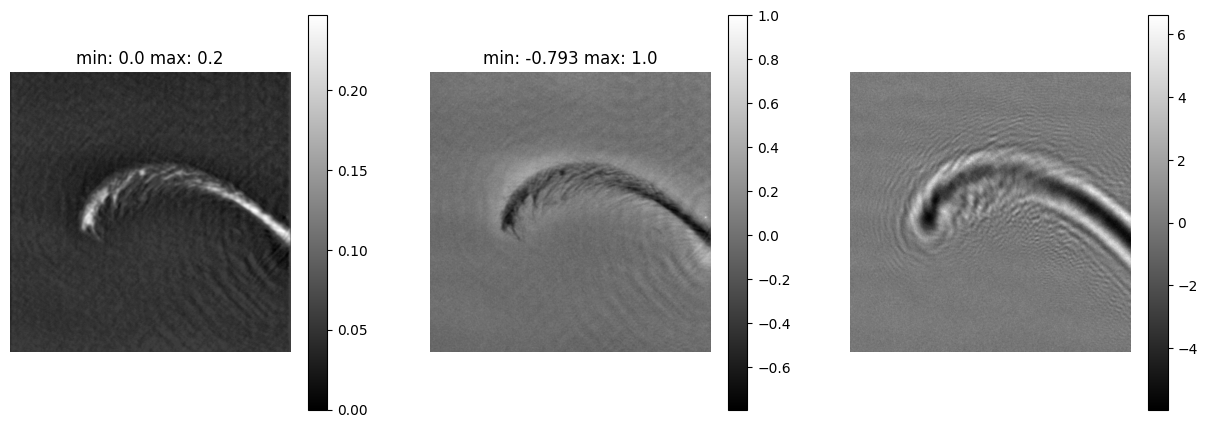

,0
experiment_name,spider_hair_0_0.001
iter,100
sum of pointwise difference,1.067575
sum of absolute value of pointwise difference,59.163509
sum of squared difference,17.296753
PSNR,[14.713054]
SSIM,[0.6885495]
NRMSE,4.158937
MSSIM,[0.9332536]
epoch_time,[14.42453]


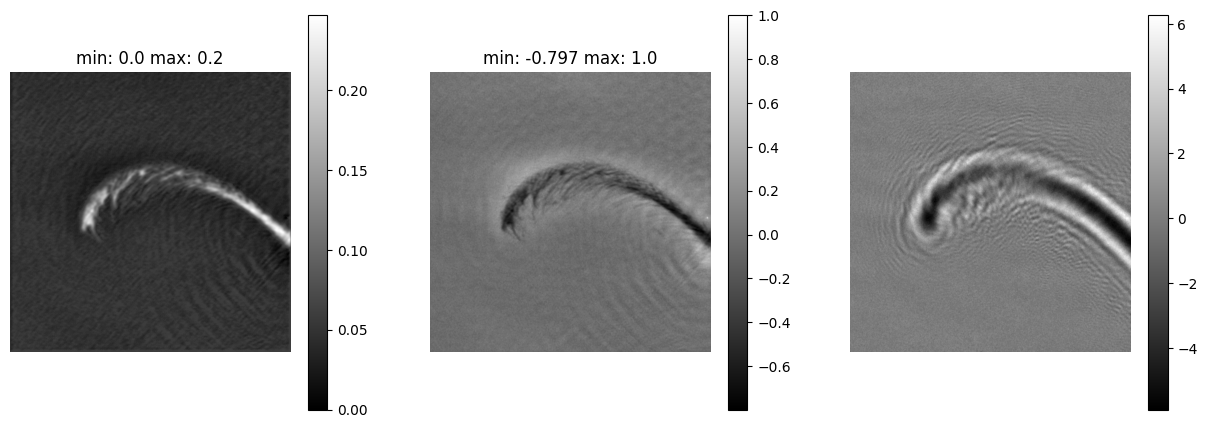

,0
experiment_name,spider_hair_1_0.001
iter,100
sum of pointwise difference,1.740725
sum of absolute value of pointwise difference,56.569382
sum of squared difference,16.163258
PSNR,[15.00741]
SSIM,[0.6899701]
NRMSE,4.020355
MSSIM,[0.93432176]
epoch_time,[14.42453]


In [266]:
abs_ratio_all = np.arange(0.01, 10*0.04, 0.004)
abs_ratio_all = 0.001*np.ones(2)

absorption = np.zeros(shape=(abs_ratio_all.shape[0], px, py), dtype=np.float32)
phase = np.zeros(shape=(abs_ratio_all.shape[0], px, py), dtype=np.float32)
propagated = np.zeros(shape=(abs_ratio_all.shape[0], px, py), dtype=np.float32)
loss = np.zeros(shape=(abs_ratio_all.shape[0], 1), dtype=np.float32)
time_count = np.zeros(shape=(abs_ratio_all.shape[0], 1), dtype=np.float32)

from ganrec_dataloader import measure_reconstruction_quality, tf_reshape, tfback_phase
kwargs['iter_num'] = 1000
kwargs['internal_iter'] = 1
kwargs['last_retrieval'] = True
kwargs['save_wpath'] = 'data/gan_phase/spider_abs_ratio/'
kwargs['init_wpath'] = 'data/gan_phase/spider_abs_ratio/'
kwargs['init_model'] = False
kwargs['save_model'] = False
kwargs['filter_type'] = 'diffuse'
side_propagations = []


for i, abs_ratio in enumerate(abs_ratio_all):
    idx = i
    gan_phase_object = GANphase(data[idx], **kwargs)
    start = time.time()
    absorption[i], phase[i],propagated[i], loss[i], side_propagation  = gan_phase_object.recon
    side_propagations.append(side_propagation)
    end = time.time()
    time_count[i] = end - start
    matched = tfback_phase( propagated[i], data[idx])
    visualize([absorption[i], phase[i], propagated[i]])#, matched, data[idx], idx, abs_ratio, kwargs['iter_num'])
    io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/phase/phase_'+str(idx)+'_'+str(abs_ratio)+'.tif', phase[i])
    io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])
    io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/propagated/propagated_'+str(idx)+'_'+str(abs_ratio)+'.tif', propagated[i])
    df = measure_reconstruction_quality(img1=tf_reshape(propagated[i]), img2 = tf_reshape(data[idx]), experiment_name = 'spider_hair_'+str(idx)+'_'+str(abs_ratio), csv_file = 'spider_hair_fixed.csv', iteration = kwargs['iter_num'], save = False, epoch_time = time_count[0], total_time = np.sum(time_count))
    display(df)

In [252]:
median filter

e	spider_hair_0_0.001
iter	100
sum of pointwise difference	1.067573
sum of absolute value of pointwise difference	73.153244
sum of squared difference	19.852489
PSNR	[14.11455]
SSIM	[0.6031478]
NRMSE	4.455613
MSSIM	[0.90151393]
epoch_time	[16.264517]
total_time	16.264517

experiment_name	spider_hair_0_0.001
iter	1000
sum of pointwise difference	1.067723
sum of absolute value of pointwise difference	16.480839
sum of squared difference	2.834337
PSNR	[22.568184]
SSIM	[0.94758195]
NRMSE	1.683549
MSSIM	[0.99486446]
epoch_time	[103.76913]
total_time	103.769127

diffuse

internal_iter = 0
experiment_name	spider_hair_0_0.001
iter	1000
sum of pointwise difference	1.067643
sum of absolute value of pointwise difference	17.683357
sum of squared difference	4.097641
PSNR	[20.96736]
SSIM	[0.9352862]
NRMSE	2.024263
MSSIM	[0.9928949]
epoch_time	[103.06528]
total_time	103.065277


internal_iter = 1
experiment_name	spider_hair_0_0.001
iter	100
sum of pointwise difference	1.067696
sum of absolute value of pointwise difference	69.379532
sum of squared difference	18.192776
PSNR	[14.49371]
SSIM	[0.6553844]
NRMSE	4.265299
MSSIM	[0.9296529]
epoch_time	[17.537016]
total_time	17.537016


experiment_name	spider_hair_1_0.001
iter	500
sum of pointwise difference	1.740331
sum of absolute value of pointwise difference	46.256245
sum of squared difference	11.329677
PSNR	[16.550524]
SSIM	[0.7720754]
NRMSE	3.365958
MSSIM	[0.96025866]
epoch_time	[56.187874]
total_time	111.658806

experiment_name	spider_hair_0_0.001
iter	1000
sum of pointwise difference	1.067929
sum of absolute value of pointwise difference	29.204779
sum of squared difference	4.473261
PSNR	[20.586458]
SSIM	[0.89105505]
NRMSE	2.115008
MSSIM	[0.98728424]
epoch_time	[103.7167]
total_time	103.716698



No filter
0
experiment_name	spider_hair_0_0.001
iter	100
sum of pointwise difference	1.067515
sum of absolute value of pointwise difference	82.197914
sum of squared difference	26.056671
PSNR	[12.933509]
SSIM	[0.56389964]
NRMSE	5.104573
MSSIM	[0.8984288]
epoch_time	[9.666689]
total_time	9.666689

experiment_name	spider_hair_0_0.001
iter	1000
sum of pointwise difference	1.067761
sum of absolute value of pointwise difference	32.422207
sum of squared difference	8.920664
PSNR	[17.588728]
SSIM	[0.8558698]
NRMSE	2.986748
MSSIM	[0.9791229]
epoch_time	[62.59106]
total_time	62.591061

0
experiment_name	spider_hair_1_0.001
iter	100
sum of pointwise difference	1.740443
sum of absolute value of pointwise difference	82.418633
sum of squared difference	26.359751
PSNR	[12.883286]
SSIM	[0.54532367]
NRMSE	5.134175
MSSIM	[0.8818328]
epoch_time	[10.032682]
total_time	19.343388

SyntaxError: invalid syntax (3286988968.py, line 4)

5 internal iter
experiment_name	spider_hair_1_0.001
iter	100
sum of pointwise difference	1.740453
sum of absolute value of pointwise difference	99.423027
sum of squared difference	31.139992
PSNR	[12.159513]
SSIM	[0.4186714]
NRMSE	5.580322
MSSIM	[0.8265521]
epoch_time	[19.044077]
total_time	36.570862

25 interal_iter
experiment_name	spider_hair_1_0.001
iter	100
sum of pointwise difference	1.740623
sum of absolute value of pointwise difference	93.28624
sum of squared difference	27.570999
PSNR	[12.688174]
SSIM	[0.45645195]
NRMSE	5.250809
MSSIM	[0.84762067]
epoch_time	[22.117128]
total_time	45.066795

125 interal iters
experiment_name	spider_hair_0_0.001
iter	100
sum of pointwise difference	1.067852
sum of absolute value of pointwise difference	93.236343
sum of squared difference	27.401783
PSNR	[12.7149105]
SSIM	[0.49531546]
NRMSE	5.234671
MSSIM	[0.87391543]
epoch_time	[46.88173]
total_time	46.881729

	0
experiment_name	spider_hair_1_0.001
iter	500
sum of pointwise difference	0.000229
sum of absolute value of pointwise difference	45.757442
sum of squared difference	12.726364
PSNR	[16.045656]
SSIM	[0.7784713]
NRMSE	3.567403
MSSIM	[0.96539605]
epoch_time	[30.902552]
total_time	62.304836

In [ ]:
experiment_name	spider_hair_1_0.001
iter	100
sum of pointwise difference	0.000195
sum of absolute value of pointwise difference	96.930626
sum of squared difference	33.696041
PSNR	[11.81691]
SSIM	[0.48920137]
NRMSE	5.804829
MSSIM	[0.8515285]
epoch_time	[9.893564]
total_time	18.99574

	0
	experiment_name	spider_hair_4_0.001
	iter	100
	sum of pointwise difference	0.000196
	sum of absolute value of pointwise difference	90.706001
	PSNR	[12.520148]
	SSIM	[0.52387065]
	NRMSE	5.353373
	MSSIM	[0.86077255]
	epoch_time	[35.9249]
	total_time	181.780594


0
experiment_name	spider_hair_4_0.001
iter	100
sum of pointwise difference	0.000195
sum of absolute value of pointwise difference	82.249924
sum of squared difference	25.856874
PSNR	[12.966938]
SSIM	[0.5756987]
NRMSE	5.084966
MSSIM	[0.8960884]
epoch_time	[13.667723]
total_time	66.62921

	0
experiment_name	spider_hair_4_0.001
iter	100
sum of pointwise difference	0.000236
sum of absolute value of pointwise difference	91.382996
sum of squared difference	30.715889
PSNR	[12.219068]
SSIM	[0.51758057]
NRMSE	5.542192
MSSIM	[0.82667786]
epoch_time	[13.224823]
total_time	65.08735

In [ ]:
experiment_name	spider_hair_1_0.001
iter	500
sum of pointwise difference	0.000213
sum of absolute value of pointwise difference	47.602768
sum of squared difference	14.301456
PSNR	[15.538897]
SSIM	[0.75350416]
NRMSE	3.781727
MSSIM	[0.9570663]
epoch_time	[33.89207]
total_time	67.845146

In [93]:
len(side_propagations[0])

650

In [236]:
visualize(side_propagations[0][240:255], rows = 3)

no images to plot


In [ ]:
	0
experiment_name	spider_hair_1_0.001
iter	500
sum of pointwise difference	0.000164
sum of absolute value of pointwise difference	48.42403
sum of squared difference	13.051403
PSNR	[15.936128]
SSIM	[0.75554806]
NRMSE	3.612673
MSSIM	[0.9601537]
epoch_time	[33.093094]
total_time	66.786987

	0
experiment_name	spider_hair_1_0.001
iter	500
sum of pointwise difference	0.000191
sum of absolute value of pointwise difference	51.718307
sum of squared difference	18.227623
PSNR	[14.485399]
SSIM	[0.70360225]
NRMSE	4.269382
MSSIM	[0.9412018]
epoch_time	[41.61035]
total_time	83.664597

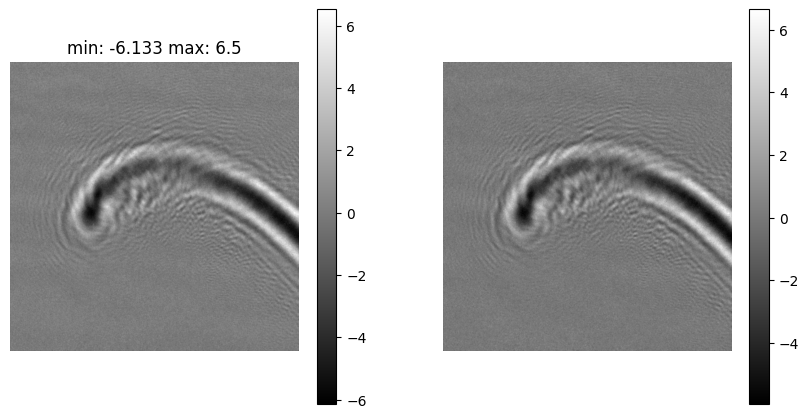

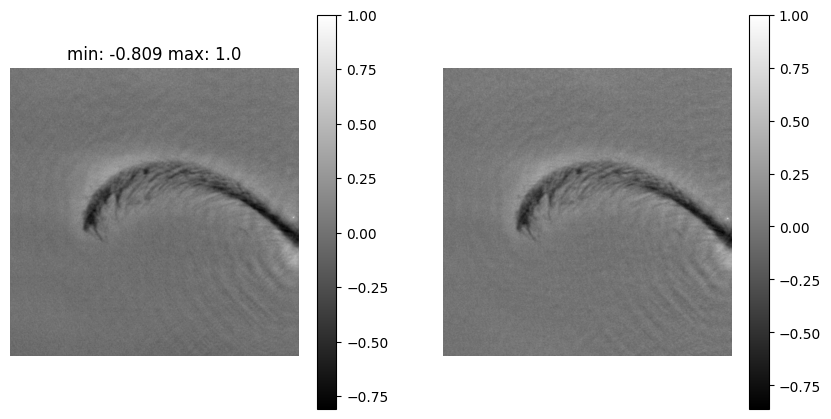

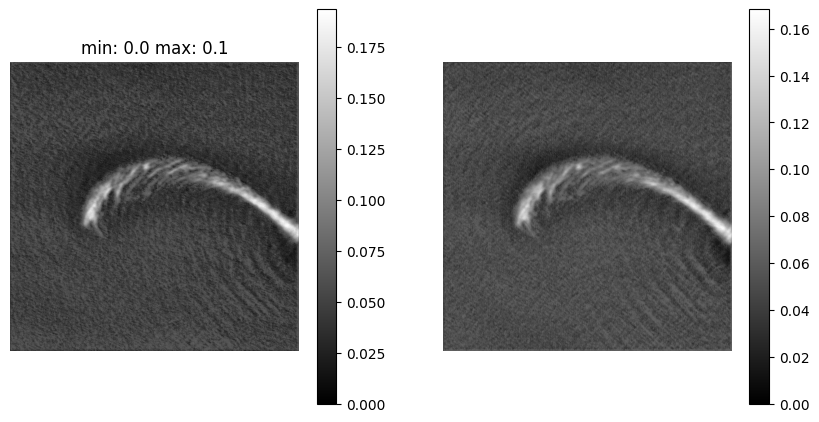

In [238]:
visualize(propagated)
visualize(phase)
visualize(absorption)

In [7]:
propagated

array([[[-0.6136665 ,  0.13302025,  0.32186016, ..., -0.09148236,
         -0.3407958 , -1.96801   ],
        [-0.35595185,  0.38774887,  0.6308885 , ...,  0.28855398,
          0.50678325,  0.39223057],
        [ 0.276201  ,  0.2667964 ,  0.38378364, ...,  0.1458897 ,
          0.48228717,  0.4459923 ],
        ...,
        [-0.38681   , -0.18051404, -0.07106716, ...,  0.18675776,
         -0.06719072, -0.21326604],
        [-0.77587706, -0.3900758 , -0.03764531, ..., -0.44485438,
         -0.62494606, -0.7273906 ],
        [-1.6328176 , -0.8473504 , -0.4484887 , ..., -0.44571254,
         -0.78750634, -0.6315395 ]],

       [[-1.4207247 , -0.3536392 ,  0.21898773, ...,  0.18329577,
          0.21277833, -0.69992083],
        [ 0.14232266,  0.4345256 ,  0.43617845, ...,  0.23075949,
          0.48353943,  0.5357598 ],
        [ 0.17370318,  0.92566955,  0.40793237, ...,  0.0261985 ,
          0.5587427 ,  0.31368807],
        ...,
        [ 0.04977625, -0.11384767,  0.13729204, ..., -